In [2]:
#standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#modeling imports
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, Normalizer

#metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn import metrics

#set a random seed to guarantee reproducible results
import random
random.seed(48)

#Set color palette for visualizations
sns.set_palette(sns.color_palette('Dark2'))


# <a name="top2"></a> US Census Data:
## A Study of Which Features Impact Income Greater or Lesser than $50,000


### Binary Classification Model


### Project Contents:
|Name|Description|
|---|---|
|1_cleaning_eda|Cleans and prepares data for modeling. Initial EDA.|
|2_modeling|Binary classification model predicting income greater or lesser than $50k.|


You are currently in notebook 2_modeling. 



#### Notebook Table of Contents

* [Reading in the transformed data](#read2)
* [Baseline model](#baseline)
* [LogisticRegression Model](#logreg)
* [RandomForest Model (BEST MODEL)](#rf)
* [KNN Model](#knn)
* [Stacking Model](#stacks)


#### Notebook summary: 
A RandomForest model proved to be the highest score modeling for both accuracy and F1 score, and as such is my chosen model. 

By examining these models, we also gain a better understanding of which characteristics are the strongest predictors of income. Highly influential characteristics include: 

* Veterans Benefits
* Stock Dividends
* Age
* Race
* Citizenship status

##### Take a closer look [below](#coef). 

### <a name="read2"></a>Reading in the raw data and metrics functions
[Jump to the top of this notebook](#top2)

In [ ]:
# import training and testing data, which was cleaned in notebook_1

model_train_df = pd.read_csv('../data/transformed_data/model_train_df.csv')
model_test_df = pd.read_csv('../data/transformed_data/model_test_df.csv')

In [58]:
# a function for scoring and pulling model metrics

def model_metrics(some_lr, scaled=False):
    '''
    input: model
    output: metrics
    '''
    if scaled:
        train_r2 = some_lr.score(X_train_sc, y_train)
        test_r2 = some_lr.score(X_test_sc, y_test)
        
    else:
        train_r2 = some_lr.score(X_train, y_train)
        test_r2 = some_lr.score(X_test, y_test)
    preds = some_lr.predict(X)
    resids_mean = (y - preds).mean()
    mae = metrics.mean_absolute_error(y, preds)
    resids = resids = y - preds
    rss = (resids ** 2).sum()
    mse = metrics.mean_squared_error(y, preds)
    rmse = np.sqrt(metrics.mean_squared_error(y, preds))
    cvs = cross_val_score(some_lr, X, y, cv=5).mean()
    f1 = f1_score(y, preds)
    class_report = classification_report(y, preds)
    print(class_report)

    final_dict={'Train R2 Score': train_r2,
                'Test R2 Score' : test_r2,
                'Mean of Residuals': resids_mean,
               'Mean Absolute Error': mae,
               'Residual Sum of Squares': rss,
               'Mean Squared Error': mse,
               'Root Mean Squared Error': rmse,
               'cross_val_score': cvs,
               'f1': f1}
    return final_dict

# a function to produce classification report

def class_report(model, x=X_test_data, y=y_test_data):
    
    '''
    input: model, X, y
    output: classification report
    '''
    preds = model.predict(x)
    class_report = classification_report(y, preds)
    print(class_report)

In [59]:
# Training data features and target
X = model_train_df.drop(columns = ['target'])
y = model_train_df['target']

# Testing data features and target
X_test_data = model_test_df.drop(columns = ['target'])
y_test_data = model_test_df['target']

### <a name="baseline"></a> Baseline Model

To determine my baseline model, I'm assuming an accuracy score equivalent to the majority class: 93.7%. 

I also built a Naive Bayes model, which actually underperformed the majority class assumption.

[Jump to the top of this notebook](#top2)

[Jump to the winning model (RandomForest)](#rf)

In [6]:
y.value_counts(normalize=True)

0    0.937942
1    0.062058
Name: target, dtype: float64

In [7]:
y_test_data.value_counts(normalize=True)

0    0.937942
1    0.062058
Name: target, dtype: float64

In [ ]:
# train, test, split on training data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, stratify=y, random_state=48)

In [ ]:
#naive bayes model for baseline testing purposes

nb = GaussianNB()
nb.fit(X_train, y_train)

In [ ]:
#score nb model using custom function

model_metrics(nb)

In [ ]:
# naive bayes classification report

class_report(nb)

### <a name="logreg"></a> Logistic Regression Model

[Jump to the top of this notebook](#top2)

[Jump to the winning model (RandomForest)](#rf)

In [14]:
logreg = LogisticRegression(max_iter=100_000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=100000)

In [15]:
model_metrics(logreg)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    187141
           1       0.66      0.24      0.35     12382

    accuracy                           0.95    199523
   macro avg       0.80      0.62      0.66    199523
weighted avg       0.93      0.95      0.93    199523



{'Train R2 Score': 0.9451188951383861,
 'Test R2 Score': 0.9445196211096076,
 'Mean of Residuals': 0.03940397848869554,
 'Mean Absolute Error': 0.054941034366965215,
 'Residual Sum of Squares': 10962,
 'Mean Squared Error': 0.054941034366965215,
 'Root Mean Squared Error': 0.23439503912618376,
 'cross_val_score': 0.9450238747408013,
 'f1': 0.3514376996805112}

In [83]:
logreg.score(X_test_data, y_test_data)

0.9450589656330348

In [52]:
f1_score(y_test_data, logreg.predict(X_test_data))

0.3514376996805112

In [55]:
recall_score(y_test_data, logreg.predict(X_test_data))

0.23986431917299306

In [18]:
# training classification report

class_report(logreg)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    187141
           1       0.66      0.24      0.35     12382

    accuracy                           0.95    199523
   macro avg       0.80      0.62      0.66    199523
weighted avg       0.93      0.95      0.93    199523



In [19]:
# testing classification report

class_report(logreg, X_test, y_test)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     18715
           1       0.64      0.24      0.35      1238

    accuracy                           0.94     19953
   macro avg       0.80      0.62      0.66     19953
weighted avg       0.93      0.94      0.93     19953



#### <a name="coef"></a> A look at the coefficients: 
##### Which characteristics are highly influential over income? 

In [20]:
coef = list(logreg.coef_)
features = list(X.columns)
income_coef = pd.DataFrame(zip(features, coef[0]), columns=['Feature', 'Coefficient'],index=features).drop(columns='Feature').sort_values(by='Coefficient', ascending=False)
income_coef

,Coefficient
veterans_benefits,0.559045
stock_dividends,0.543852
age,0.527804
num_employed,0.100315
weeks_worked,0.051261
occupation_major,0.039828
education,0.034443
employment_status,0.026645
household_summary,0.023859
industry_detailed,0.005430


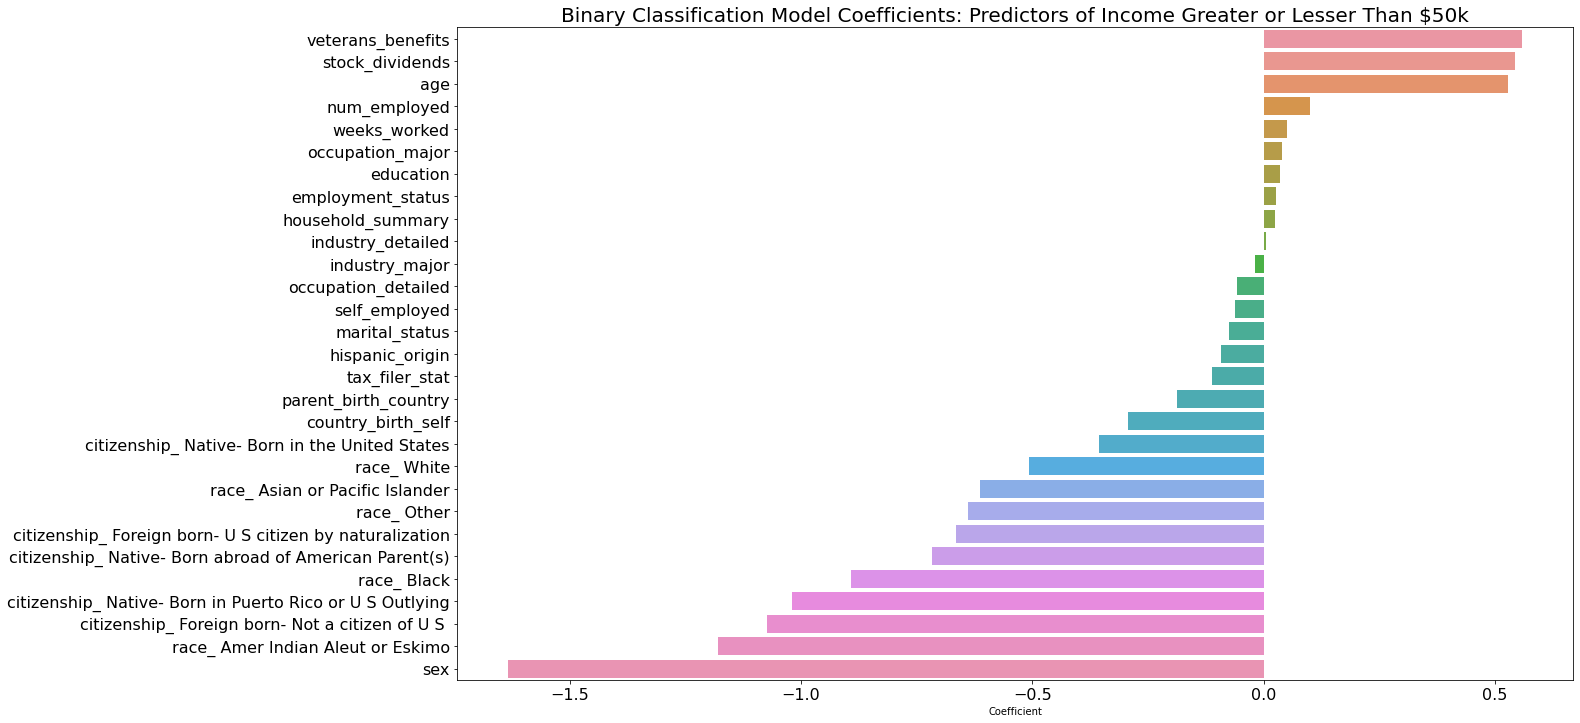

In [57]:
fig_dims = (20, 12)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y = income_coef.index, x=income_coef['Coefficient'], ax=ax)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Binary Classification Model Coefficients: Predictors of Income Greater or Lesser Than $50k', fontsize=20);

Here we can take a closer look at the coefficients from the logistic regression model. After EDA and deciding which data to use in modeling, and engineering features based on that EDA, the features that were strongest included age, veterans benefits, stock dividends, race, and citizenship. I will note that I was heavily focused on societal demographics versus occupation, and that comes out in my results. I do think that further study should be given to a cross examination of demographics with occupation and industry codes, and that would certainly be my next step in this study. 

<Figure size 1440x1440 with 0 Axes>

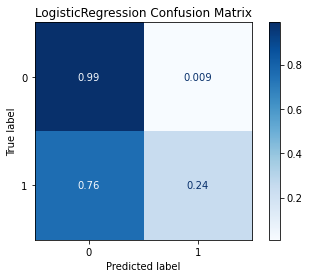

In [60]:
# Training Data

plt.figure(figsize=(20, 20))
plot_confusion_matrix(logreg, X_test, y_test, cmap='Blues', normalize='true')
plt.title('LogisticRegression Confusion Matrix');

<Figure size 1440x1440 with 0 Axes>

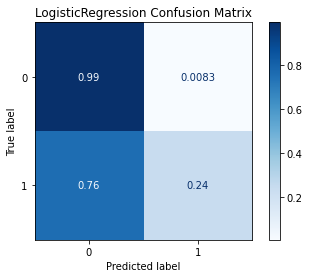

In [23]:
# Testing Data

plt.figure(figsize=(20, 20))
plot_confusion_matrix(logreg, X_test_data, y_test_data, cmap='Blues', normalize='true')
plt.title('LogisticRegression Confusion Matrix');

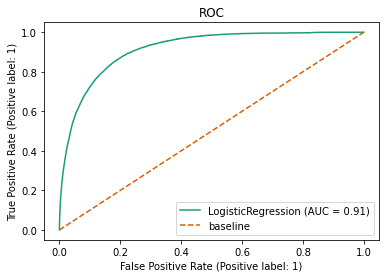

In [24]:
#ROC curve - Testing data
plot_roc_curve(logreg, X_test_data, y_test_data)
plt.plot([0,1], [0,1], label = 'baseline', linestyle= '--')
plt.title('ROC')
plt.legend();

### <a name="rf"></a> RandomForest Model (Best Model)

The strongest performing model was a randomforest model, which gave me a well fit model hovering around 99% accuracy for both training and testing data, and an f1 score of .9. 

[Jump to the top of this notebook](#top2)


In [42]:
#instantiate and fit randomforest on training data

rf = RandomForestClassifier(random_state=48)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=48)

In [43]:
#training metrics

model_metrics(rf)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    187141
           1       0.95      0.86      0.90     12382

    accuracy                           0.99    199523
   macro avg       0.97      0.93      0.95    199523
weighted avg       0.99      0.99      0.99    199523



{'Train R2 Score': 0.9929665311577658,
 'Test R2 Score': 0.9445196211096076,
 'Mean of Residuals': 0.006084511560070769,
 'Mean Absolute Error': 0.011878329816612621,
 'Residual Sum of Squares': 2370,
 'Mean Squared Error': 0.011878329816612621,
 'Root Mean Squared Error': 0.10898775076407725,
 'cross_val_score': 0.9461265027545874,
 'f1': 0.8993630573248408}

In [44]:
# testing data classification report

class_report(rf)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    187141
           1       0.95      0.86      0.90     12382

    accuracy                           0.99    199523
   macro avg       0.97      0.93      0.95    199523
weighted avg       0.99      0.99      0.99    199523



In [45]:
#testing data f1 score

f1_score(y_test_data, rf.predict(X_test_data))

0.8993630573248408

In [56]:
#testing data recall score

recall_score(y_test_data, rf.predict(X_test_data))

0.8552737845259247

In [50]:
# training accuracy score

rf.score(X_train, y_train)

0.9929665311577658

In [51]:
# testing accuracy score

rf.score(X_test_data, y_test_data)

0.9881216701833874

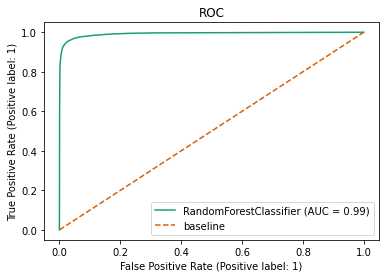

In [46]:
#ROC curve - testing data
plot_roc_curve(rf, X_test_data, y_test_data)
plt.plot([0,1], [0,1], label = 'baseline', linestyle= '--')
plt.title('ROC')
plt.legend();

<Figure size 1440x1440 with 0 Axes>

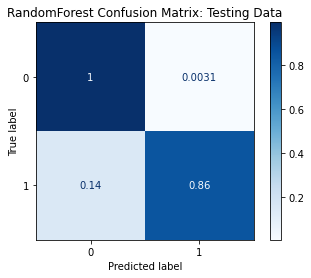

In [61]:
# Testing Data

plt.figure(figsize=(20, 20))
plot_confusion_matrix(rf, X_test_data, y_test_data, cmap='Blues', normalize='true')
plt.title('RandomForest Confusion Matrix: Testing Data');

In [18]:
#Gridsearch of randomforest model will take a significant amount of time to run. Unccoment the code below to run this gridsearch

# rf_params = {
#     'criterion': ['gini','entropy'],
#     'min_samples_split': [2, 4],
#     'n_estimators': [3, 5],
#     'class_weight': ['balanced', 'balanced_subsample'],
#     'ccp_alpha': [.0001, .001, .01, .1]

# }

# rf_gridsearch = GridSearchCV(RandomForestClassifier(), 
#                               rf_params, 
#                               cv=5, 
#                               verbose=1)

# rf_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'ccp_alpha': [0.0001, 0.001, 0.01, 0.1],
                         'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'min_samples_split': [2, 4], 'n_estimators': [3, 5]},
             verbose=1)

In [19]:
#uncomment code below to get best_param from rf gridsearch

# rf_gridsearch.best_params_

{'ccp_alpha': 0.0001,
 'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'min_samples_split': 2,
 'n_estimators': 5}

In [20]:
#uncomment code below to get best_score from rf gridsearch

# rf_gridsearch.best_score_

0.9039895245758061

### <a name="stacks"></a> Stacking Classifier

[Jump to the top of this notebook](#top2)

[Jump to the winning model (RandomForest)](#rf)

In [48]:
estimators = [('knn', KNeighborsClassifier(p=1)),
              ('tree', DecisionTreeClassifier(random_state=42))]

stacks = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(), cv=3)

stacks.fit(X_train, y_train)


StackingClassifier(cv=3,
                   estimators=[('knn', KNeighborsClassifier(p=1)),
                               ('tree',
                                DecisionTreeClassifier(random_state=42))],
                   final_estimator=RandomForestClassifier())

In [49]:
stacks.score(X_test_data, y_test_data)

0.9611473363973075

### <a name="knn"></a> KNN Model

[Jump to the top of this notebook](#top2)

[Jump to the winning model (RandomForest)](#rf)

In [63]:
#scaling data in preparation for KNN model
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [64]:
knn = KNeighborsClassifier(p=1)
knn.fit(X_train_sc, y_train)

KNeighborsClassifier(p=1)

In [65]:
knn.score(X_test_sc, y_test)

0.9409111411817772

In [ ]:
knn.score(X_train_sc, y_train)